In [7]:
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.constants import G
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rc
rc('text', usetex=True)
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

In [2]:
data = Table.read('Astr511HW1data.dat.gz', format='ascii')

In [ ]:
u = np.array(data['u'])
g = np.array(data['g'])
r = np.array(data['r'])
i = np.array(data['i'])
z = np.array(data['z'])

u_g = u - g
g_r = g - r
g_i = g - i

x = u_g
y = g_r

$$\Delta{M_r}([\textrm{Fe}/\textrm{H}]) = 4.50 - 1.11[\textrm{Fe}/\textrm{H}] - 0.18[\textrm{Fe}/\textrm{H}]^2$$

$${M_r}(g-i,[\textrm{Fe}/\textrm{H}]) = M_r^0(g-i) + \Delta{M_r}([\textrm{Fe}/\textrm{H}])$$

$$([\textrm{Fe}/\textrm{H}]) =  A + Bx + Cy + Dxy + Ex^2 + Fy^2 + Gx^2y + Hxy^2 + Ix^3 + Jy^3$$

In [4]:
ndata = x.shape[0]

A_J = np.array([-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20])
features = np.array([np.ones(ndata), x, y, x*y, x**2, y**2, x**2*y, x*y**2, x**3, y**3])

feh = np.dot(A_J, features)

feh[np.where(y > 0.6)[0]] = -0.6

In [5]:
# M_r0 = -2.85 + 6.29*g_i - 2.30*g_i**2
M_r0 = -5.06 + 14.32*g_i - 12.97*g_i**2 + 6.127*g_i**3 - 1.267*g_i**4 + 0.0967*g_i**5
dM_r = 4.50 - 1.11*feh - 0.18*feh**2
M_r  = M_r0 + dM_r

D = 10**((r - M_r)/5 + 1)
Z = D

In [23]:
df = pd.DataFrame(data={'g_r':g_r, 'feh':feh, 'M_r':M_r, 'D':Z/1e3})

### Question 1

In [92]:
dOmega = 314 / (180/np.pi)**2  # convert deg^2 to sterradians
dD = 1

Dbins = np.arange(0,26,dD)
Dbin_cent = np.arange(dD/2,26,dD)
dV = dOmega * (Dbin_cent)**2 * dD
# dV = dOmega * dD * (np.arange(1,27,dD)**2 - np.arange(0,26,dD)**2)

sel = df[df['g_r'] < 0.4][df['g_r'] > 0.2]

/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [93]:
dN = []
for dbin in Dbins:
    dN.append(len(np.where((sel['D'] > dbin) & (sel['D'] < dbin+dD))[0]))
dN = np.array(dN)

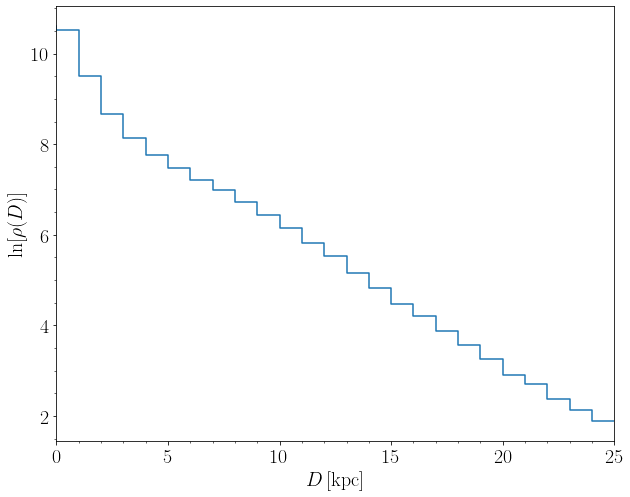

In [96]:
plt.figure(figsize=[10,8])
plt.step(Dbins, np.log(dN/dV))
plt.ylabel(r'$\ln[\rho(D)]$', fontsize=20)
plt.xlabel(r'$D \, \rm [kpc]$', fontsize=20)
plt.xlim(min(Dbins), max(Dbins))
plt.minorticks_on()
plt.savefig('plot1.png')
plt.show()

In [34]:
# plt.hist(sel['D']/dV, bins=zbins, histtype='step')
# plt.show()

### Question 2